### Домашняя работа №8

Построить модель градиентного бустинга для показателя частоты страховых убытков. Можно предобработать исходные данные, добавив дополнительные фичи. Также можно использовать различные методы для подбора гиперпараметров. Оценить результаты построенного классификатора, выявить возможные проблемы. Сравнить результаты с полученным ранее результатом с использованием Пуассоновской регрессии. Проанализировать результаты, предложить способы решения обнаруженных проблем и/или попробовать его улучшить.

В текущем домашнем задание предлагается взглянуть на задачу моделирования количества страховых случаев как на задачу многоклассовой классификации.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from skll.metrics import kappa
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

In [2]:
def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [3]:
df = pd.read_csv('freMPL-R.csv', low_memory=False)

In [4]:
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

Предобработайте данные

In [5]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
82,-74.206042,0
175,-1222.585196,0
177,-316.288822,0
363,-666.758610,0
375,-1201.600604,0


In [6]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

In [7]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)

{0: 'Male', 1: 'Female'}


In [8]:
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Other', 1: 'Alone'}


In [9]:
list(df.VehUsage.unique())

['Professional', 'Private+trip to office', 'Private', 'Professional run']

In [10]:
VU_dummies = pd.get_dummies(df.VehUsage, prefix='VehUsg', drop_first=False)
VU_dummies.head()

,VehUsg_Private,VehUsg_Private+trip to office,VehUsg_Professional,VehUsg_Professional run
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,1,0,0,0


In [11]:
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)

In [12]:
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])

In [13]:
df = df.select_dtypes(exclude=['object'])

In [14]:
df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)
df.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,ClaimNbResp,...,VehUsage_Professional,VehUsage_Professional run,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,DrivAgeSq
0,0.083,332,0,0,46,0,50,0.0,0,0.0,...,1,0,0,0,0,0,1,0,0,2116
1,0.916,333,0,0,46,0,50,0.0,0,0.0,...,1,0,0,0,0,0,1,0,0,2116
2,0.550,173,0,0,32,0,68,0.0,0,0.0,...,0,0,0,0,0,0,1,0,0,1024
3,0.089,364,1,0,52,0,50,0.0,0,0.0,...,0,0,0,0,0,0,1,0,0,2704
4,0.233,426,0,0,57,0,50,0.0,0,0.0,...,0,0,0,0,0,0,0,1,0,3249


In [15]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [16]:
pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

,Policies
0.0,104286
2.0,3529
1.0,3339
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6
9.0,2


In [17]:
dfAC = df[df.ClaimsCount > 0].copy()
dfAC['AvgClaim'] = dfAC.ClaimAmount/dfAC.ClaimsCount

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 24 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Exposure                         115155 non-null  float64
 1   LicAge                           115155 non-null  int64  
 2   Gender                           115155 non-null  int64  
 3   MariStat                         115155 non-null  int64  
 4   DrivAge                          115155 non-null  int64  
 5   HasKmLimit                       115155 non-null  int64  
 6   BonusMalus                       115155 non-null  int64  
 7   ClaimAmount                      115155 non-null  float64
 8   ClaimInd                         115155 non-null  int64  
 9   OutUseNb                         115155 non-null  float64
 10  RiskArea                         115155 non-null  float64
 11  VehUsage_Private                 115155 non-null  uint8  
 12  Ve

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Заменим значение 11 на 10.

In [19]:
df.loc[df.ClaimsCount > 10, 'ClaimsCount'] = 10

Посмотрим, сколько полисов соответствуют каждому из значений `ClaimsCount`, используя метод `groupby`. Для полученных значений также посчитаем нормированную частоту.

In [20]:
FreqCount = pd.DataFrame(df.groupby('ClaimsCount').size(), columns=['Count'])
FreqCount['Freq'] = FreqCount.Count / np.sum(FreqCount.Count)

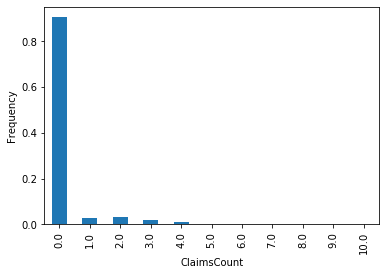

In [21]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [22]:
FreqCount

,Count,Freq
ClaimsCount,,
0.0,104286,0.905614
1.0,3339,0.028996
2.0,3529,0.030646
3.0,2310,0.020060
4.0,1101,0.009561
5.0,428,0.003717
6.0,127,0.001103
7.0,26,0.000226
8.0,6,0.000052


Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.05` для значений `ClaimsCount` 0, а для остальных - 1 (Для этого можем использовать функцию `np.where`). Также можно попробовать какой-либо другой способ задания весов, приведенный пример не гарантирует хороших результатов.

In [23]:
df['weight'] = np.where(df.ClaimsCount < 1, 0.05, 1)

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [24]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['ClaimInd', 'ClaimAmount', 'ClaimsCount'], axis=1), df.ClaimsCount, test_size=0.3, random_state=10)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

In [25]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17274 entries, 106925 to 85401
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Exposure                         17274 non-null  float64
 1   LicAge                           17274 non-null  int64  
 2   Gender                           17274 non-null  int64  
 3   MariStat                         17274 non-null  int64  
 4   DrivAge                          17274 non-null  int64  
 5   HasKmLimit                       17274 non-null  int64  
 6   BonusMalus                       17274 non-null  int64  
 7   OutUseNb                         17274 non-null  float64
 8   RiskArea                         17274 non-null  float64
 9   VehUsage_Private                 17274 non-null  uint8  
 10  VehUsage_Private+trip to office  17274 non-null  uint8  
 11  VehUsage_Professional            17274 non-null  uint8  
 12  VehUsage_Prof

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [26]:
y_train = y_train.astype(int)
y_valid = y_valid.astype(int)
y_test = y_test.astype(int)

In [27]:
xgb_train = xgb.DMatrix(x_train.drop(['Exposure', 'weight'], axis=1), (y_train), weight=x_train['weight'])
xgb_valid = xgb.DMatrix(x_valid.drop(['Exposure', 'weight'], axis=1), (y_valid))
xgb_test = xgb.DMatrix(x_test.drop(['Exposure', 'weight'], axis=1), (y_test))

Для оптимизации гиперпараметров можно воспользоваться различными методами.

In [28]:
def kappa_metric(preds, dtrain):
    labels = dtrain.get_label()
    return 'kappa', -kappa(labels, preds, weights='quadratic')

In [29]:
# Определим функцию для оптимизации гиперпараметров алгоритмом TPE

def objective(params):
    """
    Objective function for hyperopt. Optimizing mean cross-validation error with XGBoost.

    :param params: dict object passed to hyperopt fmin() function
    :return: float, mean cross-validation error for XGBoost utilizing params
    """
    params['max_depth'] = int(params['max_depth'])
    n_b_r = int(params.pop('num_boost_round'))
    data = params.pop('data')
    feval = params.pop('feval')
    nfold = params.pop('nfold')
    e_s_r = params.pop('early_stopping_rounds')
    maximize = params.pop('maximize')
    cv_result = xgb.cv(params, data, num_boost_round=n_b_r, nfold=nfold, seed=0, maximize=maximize,
                       feval=feval, early_stopping_rounds=e_s_r)
    name, _ = feval(data.get_label(), data)
    score = cv_result['test-{}-mean'.format(name)][-1:].values[0]
    return score

In [30]:
# Определим границы, в которых будем искать гиперпараметры

space_freq = {'data': xgb_train,
              'objective': 'multi:softmax',
              'num_class': 11,
              'feval': kappa_metric,
              'maximize': False,
              'nfold': 5,
              'early_stopping_rounds': 20,
              'num_boost_round': hp.choice('num_boost_round', [50, 300, 500]),
              'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
              'min_child_weight': hp.uniform('min_child_weight', 0, 50),
              'subsample': hp.uniform('subsample', 0.5, 1),
              'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
              'alpha': hp.uniform('alpha', 0, 1),
              'lambda': hp.uniform('lambda', 0, 1),
              'eta': hp.uniform('eta', 0.01, 1),
              }

In [31]:
# Оптимизация (количество итераций снижено для ускорения работы)

best = fmin(fn=objective, space=space_freq, algo=tpe.suggest, max_evals=20)

100%|██████████| 20/20 [1:44:49<00:00, 314.48s/trial, best loss: -0.053010999999999996]


In [32]:
# Оптимальные гиперпараметры 

best_params = space_eval(space_freq, best)
best_params

{'alpha': 0.17978759293581703,
 'colsample_bytree': 0.9934447237082911,
 'data': <xgboost.core.DMatrix at 0x1d200c7a608>,
 'early_stopping_rounds': 20,
 'eta': 0.5511208274477938,
 'feval': <function __main__.kappa_metric(preds, dtrain)>,
 'lambda': 0.7723820573006864,
 'max_depth': 8,
 'maximize': False,
 'min_child_weight': 45.106471844104746,
 'nfold': 5,
 'num_boost_round': 300,
 'num_class': 11,
 'objective': 'multi:softmax',
 'subsample': 0.8507646006329617}

Далее обучим нашу модель с оптимальными параметрами

In [33]:
def train_xgb_best_params(params, dtrain, evals, early_stopping_rounds, evals_result=None, verbose_eval=None):
    """
    Function to train XGBoost estimator from set of parameters, passed from hyperopt.

    :param params: dict, hyperparameters from hyperopt space_eval() function
    :param dtrain: xgb.DMatrix object, to train model on
    :param evals: list of pairs (DMatrix, str). Same from xgb.train().
    :param early_stopping_rounds: int. Same from xgb.train().
    :param evals_result: dict. Same from xgb.train().
    :param verbose_eval: bool or int. Same from xgb.train().
    :return: xgb.Booster object, trained model
    """
    par = params.copy()
    for label in ['nfold', 'data', 'early_stopping_rounds']:
        del par[label]
    n_b_r = int(par.pop('num_boost_round'))
    maximize = par.pop('maximize')
    feval = par.pop('feval')
    return xgb.train(params=par, dtrain=dtrain, num_boost_round=n_b_r, evals=evals, feval=feval, maximize=maximize,
                     early_stopping_rounds=early_stopping_rounds, evals_result=evals_result, verbose_eval=verbose_eval)

In [34]:
# Построение модели с ранней остановкой (early stopping)

progress = dict()
xgb_multiclass = train_xgb_best_params(best_params, xgb_train, [(xgb_train, "train"), (xgb_valid, "valid")], early_stopping_rounds=20, evals_result=progress, verbose_eval=False)

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью `plt.imshow()`. Можно использовать предложенный ниже код.

In [35]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test}]
for dfset in dfsets:
    class_preds = xgb_multiclass.predict(dfset['dmat']) # Посчитаем предсказанные значения
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds, average='micro')) # Посчитаем F1 Score

F1 Score on train: 0.6868300913060739
F1 Score on valid: 0.6650263416893417
F1 Score on test: 0.6630195669792752


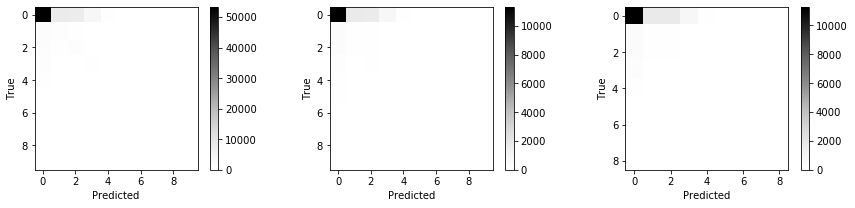

In [36]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb_multiclass.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

Для данного датасета качество построенной модели я оцениваю как низкое, значения метрики f1 требуют повышения. Вполне возможно, что построенная модель может показать приемлемые результаты для выборки с меньшим дисбалансом классов. Оснавная проблема здесь на мой взгляд это сильный дисбаланс изначальных двух классов, и эта проблема не решилась путем увеличения классов, т.к. повторюсь изначальный дисбаланс слишком велик и количество данных для обучения и определения классов 1-10 слишком мало. Решение этой проблемы на данном этапе возможно за счет увеличения количества наблюдений, что сделает обучение на большем количестве данных более эффективным.